In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.sparse import hstack
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from textblob import TextBlob


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
bnb_data = pd.read_csv('../src/data/processsed/sf_airbnb_listings_cleaned.csv')

In [3]:
bnb_data.dtypes

Unnamed: 0                     int64
Unnamed: 0.1                   int64
summary                       object
space                         object
description                   object
house_rules                   object
host_listings_count            int64
host_total_listings_count      int64
neighborhood                  object
zipcode                       object
latitude                     float64
longitude                    float64
is_location_exact             object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
amenities                     object
price                          int64
minimum_nights                 int64
maximum_nights                 int64
availability_30                int64
availability_60                int64
availability_90                int64
availability_365               int64
number_of_reviews              int64
r

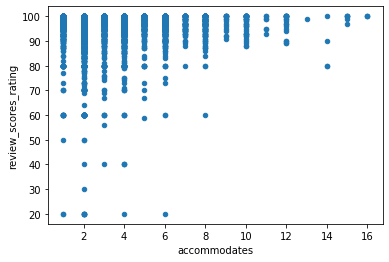

In [4]:
bnb_data.plot.scatter(x='accommodates', y='review_scores_rating')

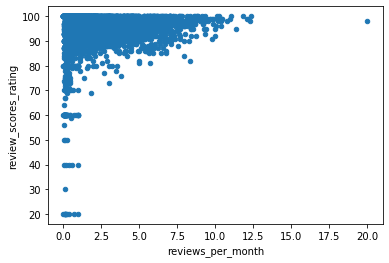

In [5]:
bnb_data.plot.scatter(x='reviews_per_month', y='review_scores_rating')

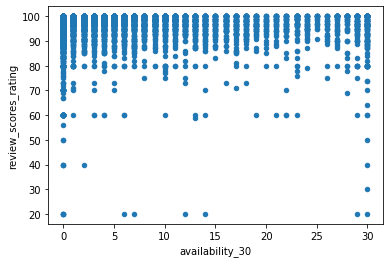

In [6]:
bnb_data.plot.scatter(x='availability_30', y='review_scores_rating')

We collect two metrics with text data -- sentiment and length

In [7]:
text_cols = ['house_rules', 'summary', 'space', 'description']

for col in text_cols:
    bnb_data[col] = bnb_data[col].fillna('')

def text_len(row):
    total = 0
    for col in text_cols:
        total += len(row[col])
    return total

def analyze_tone(row):
    total = 0
    for col in text_cols:
        if row[col]:
            blob = TextBlob(row[col])
            total += blob.sentiment.polarity
        
    return total

bnb_data['sentiment'] = bnb_data.apply(
    lambda r: analyze_tone(r),
    axis=1
)

bnb_data['text_len'] = bnb_data.apply(
    lambda r: text_len(r),
    axis=1
)

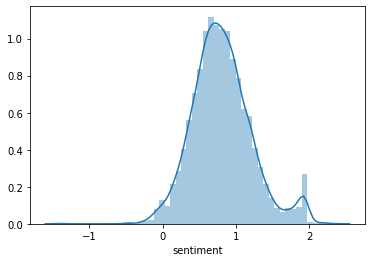

In [8]:
sns.distplot(bnb_data['sentiment'])

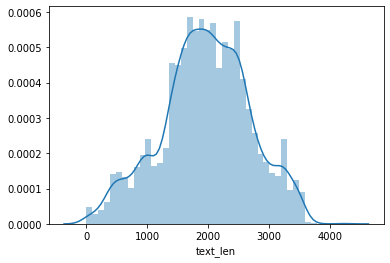

In [9]:
sns.distplot(bnb_data['text_len'])

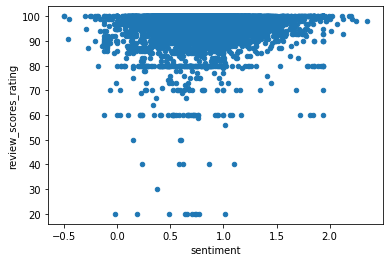

In [10]:
bnb_data.plot.scatter(x='sentiment', y='review_scores_rating')

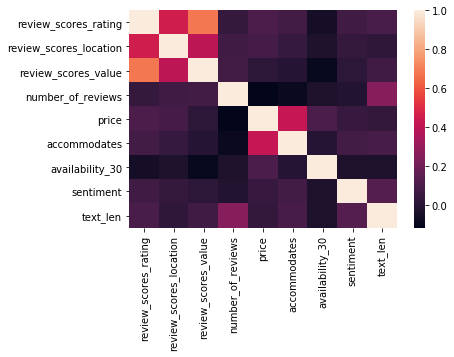

In [11]:
mat = bnb_data[['review_scores_rating', 'review_scores_location', 'review_scores_value', 'number_of_reviews', 'price', 'accommodates', 'availability_30',  'sentiment', 'text_len']].corr()
sns.heatmap(mat)


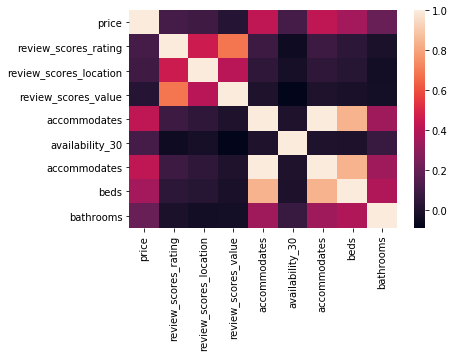

In [12]:
mat = bnb_data[['price', 'review_scores_rating', 'review_scores_location', 'review_scores_value', 'accommodates', 'availability_30', 'accommodates', 'beds', 'bathrooms']].corr()
sns.heatmap(mat)

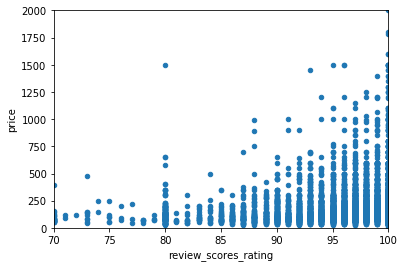

In [13]:
bnb_data.plot.scatter(x='review_scores_rating', y='price', xlim=(70, 100), ylim=(0, 2000))

bnb_data.plot.scatter(x='sentiment', y='price', s=1, xlim=(-0.5, 2), ylim=(0, 2000))

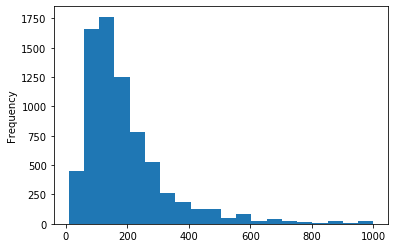

In [14]:
bnb_data.query('price < 1000')['price'].plot.hist(bins=20)

/home/alex/EECS_731/EECS731_FinalProject/.venv/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/alex/EECS_731/EECS731_FinalProject/.venv/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/alex/EECS_731/EECS731_FinalProject/.venv/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


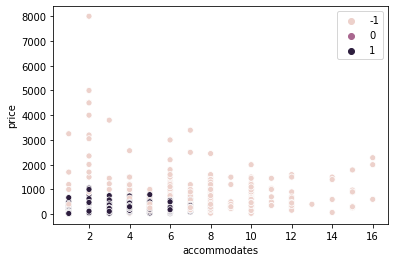

In [15]:
anom = IsolationForest()
anomaly = anom.fit_predict(bnb_data[['price', 'accommodates', 'beds', 'bathrooms', 'bedrooms']])

sns.scatterplot(bnb_data['accommodates'], bnb_data['price'], anomaly)

bnb_data = pd.concat([bnb_data, pd.DataFrame(data=anomaly, columns=['anomaly'])], axis=1)
bnb_data = bnb_data.query('anomaly == 1')

In [16]:
def run_model(model_name, model_factory, data, x_cols):
    X_train, X_test, y_train, y_test = train_test_split(data[x_cols], data['price'], test_size=.2, random_state=0)
    
    m = model_factory()
    m.fit(X_train, y_train)
    
    train_accuracy = m.score(X_train, y_train)
    test_accuracy = m.score(X_test, y_test)
    
    preds = m.predict(X_test)
    
    avg_deviation = sum([abs(pred-price)/price for (pred, price) in zip(preds, data['price'])])/len(preds)
    
    print(model_name)
    print(f'Accuracy on training data: {train_accuracy}')
    print(f'Accuracy on test data: {test_accuracy}')
    print(f'Average deviation: {avg_deviation}')
    sns.scatterplot(x=y_test, y=preds)
    
    return m


Ok results without any big feature engineering.  Text features are not good predictors of price

Gradient Boost
Accuracy on training data: 0.4553401626794895
Accuracy on test data: 0.47633446890603803
Average deviation: 0.7083260603173127


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

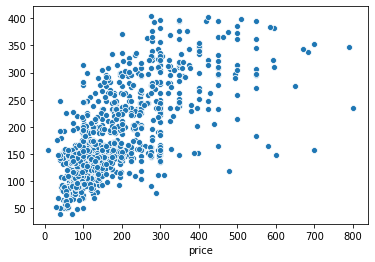

In [17]:
train_data = bnb_data.query('not review_scores_rating.isnull() and not review_scores_location.isnull()')

reg_cols = ['review_scores_rating', 'review_scores_location', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30']

run_model('Gradient Boost', GradientBoostingRegressor, train_data, reg_cols)

In [27]:
bnb_data['supervisor_district'].unique()

array([8.0, 9.0, 5.0, 2.0, 10.0, 3.0, 6.0, 1.0, 7.0, 4.0, 11.0, ''],
      dtype=object)

In [26]:
def do_onehots(data, cols):
    for col in cols:
        data[col] = data[col].fillna('')
    
    encodings = []
    onehot_cols = []
    for col in cols:
        encodings.append( pd.get_dummies(data[col], prefix=col) )
        onehot_cols += [col + '_' + x for x in data[col].unique()]
    
    return pd.concat([data] + encodings, axis=1), onehot_cols

bnb_data.app
bnb_data_onehot, onehot_cols = do_onehots(bnb_data, ['room_type', 'neighborhood', 'zipcode', 'supervisor_district'])

TypeError: must be str, not float

Linear Regression
Accuracy on training data: 0.4783430557030792
Accuracy on test data: 0.5051619000809768
Average deviation: 0.7205237003240491


,0,importance
62,zipcode_94123,112.605227
15,neighborhood_Downtown/Civic Center,79.833261
55,zipcode_94121,75.625910
7,room_type_Entire home/apt,60.986247
72,zipcode_94158,57.251125
37,neighborhood_North Beach,56.366590
60,zipcode_94104,47.438970
4,bedrooms,42.246404
28,neighborhood_Russian Hill,42.054900
25,neighborhood_Pacific Heights,34.348465


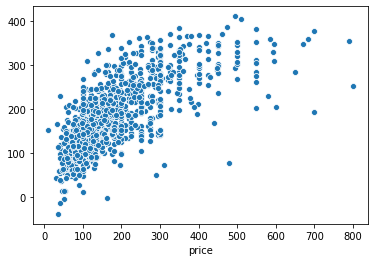

In [19]:
train_data = bnb_data_onehot.query('not review_scores_rating.isnull() and not review_scores_location.isnull()')

reg_cols = ['review_scores_rating', 'review_scores_location', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'availability_30'] + onehot_cols

reg_model = run_model('Linear Regression', LinearRegression, train_data, reg_cols)

coefficients = pd.concat([pd.DataFrame(reg_cols),pd.DataFrame(data=reg_model.coef_, columns=['importance'])], axis = 1)
coefficients.sort_values('importance', ascending=False)

/home/alex/EECS_731/EECS731_FinalProject/.venv/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest
Accuracy on training data: 0.8658951577271993
Accuracy on test data: 0.4226294459439718
Average deviation: 0.7496315963356148


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

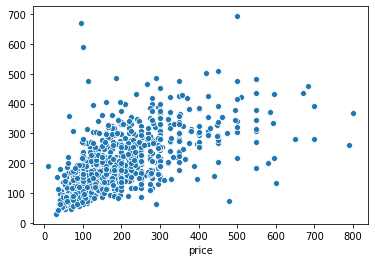

In [20]:
run_model('Random Forest', RandomForestRegressor, train_data, reg_cols)

Gradient Boost
Accuracy on training data: 0.547546551020125
Accuracy on test data: 0.5323168154157871
Average deviation: 0.7021684811553232


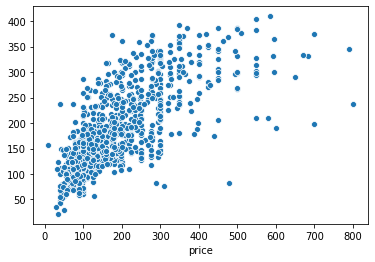

In [21]:
reg_model = run_model('Gradient Boost', lambda: GradientBoostingRegressor(loss='ls'), train_data, reg_cols)

In [22]:
km_data = train_data[['sentiment', 'review_scores_location', 'accommodates', 'price']]
norm_data = (km_data-km_data.min())/(km_data.max()-km_data.min())

km = KMeans(5)
labels = km.fit_predict(norm_data)

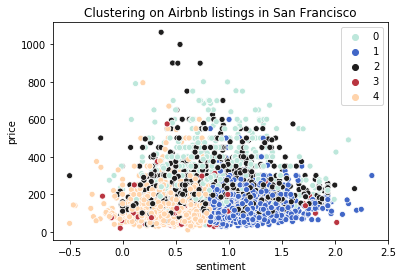

In [23]:
plot = sns.scatterplot(train_data['sentiment'], train_data['price'], labels, palette="icefire", legend="full").set_title('Clustering on Airbnb listings in San Francisco')
fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_1.png', dpi=300, transparent=True, format="png")

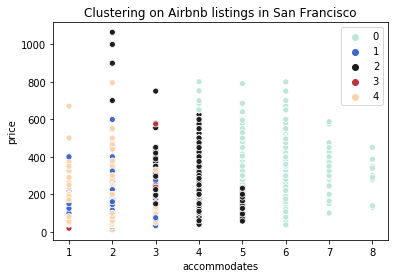

In [24]:
plot = sns.scatterplot(train_data['accommodates'], train_data['price'], labels, palette="icefire", legend="full").set_title('Clustering on Airbnb listings in San Francisco')

fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_2.png', dpi=300, transparent=True, format="png")

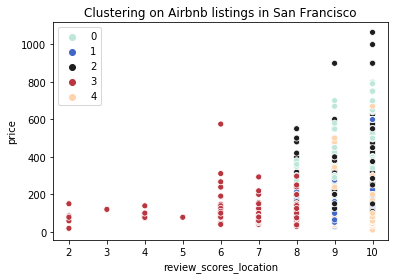

In [25]:
plot = sns.scatterplot(train_data['review_scores_location'], train_data['price'], labels, palette="icefire", legend="full").set_title('Clustering on Airbnb listings in San Francisco')

fig = plot.get_figure()
fig.savefig( 'airbnb_cluster_3.png', dpi=300, transparent=True, format="png")